<a href="https://colab.research.google.com/github/FaridRash/IGNIS/blob/main/MA_SNR_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from ipywidgets import interact, FloatSlider

#Github

In [2]:
!git clone https://github.com/FaridRash/IGNIS

Cloning into 'IGNIS'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 359 (delta 77), reused 68 (delta 21), pack-reused 204 (from 1)
Receiving objects: 100% (359/359), 44.38 MiB | 7.60 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Updating files: 100% (47/47), done.


In [3]:
!rm -rf /content/IGNIS/FoV\ visualization
!rm -rf /content/IGNIS/Notebooks/
!rm -rf /content/IGNIS/Reports/
!rm -rf /content/IGNIS/Requests/
!rm -rf /content/IGNIS/SNR\ Visualization

#Dataset

In [4]:
df = pd.read_csv("/content/IGNIS/Dataset/df_excel_with_temperature.csv")
df.head()

,Altitude,Theta,Hour,Month,Day,GSD,North,South,West,East,Background Temperature
0,461.218874,21.299047,02:00,1,2,76.025089,40.829036,40.828186,14.144160,14.145534,286.143799
1,462.767619,12.416525,02:00,1,5,76.280377,40.829036,40.828186,14.144157,14.145531,287.206543
2,463.422734,14.037020,02:00,1,5,76.388363,40.829036,40.828186,14.144156,14.145530,287.206543
3,466.582339,22.475595,15:00,1,5,76.909177,40.829036,40.828186,14.144150,14.145524,288.963867
4,466.012605,13.759815,15:00,1,5,76.815265,40.829036,40.828186,14.144151,14.145525,288.963867


#Constants

In [5]:
c1 = 3.7418e8
c2 = 1.4388e4
h = 6.626e-34
c = 3e8

In [6]:
epsilon = 0.95
tau_0 = 0.89
eta = 0.7
t = 0.01
focal_length = 72.8
F_number = 1.05
D = (focal_length / F_number) / 1000
NEDT = 0.0441 # NEDT = 44.1mK
lambda_range = np.arange(8, 14.1, 0.1)
delta_lambda = 0.1

#Variables

In [7]:
tau_a = 0.5
Tt = 413.15
At = 100

#Functions

In [8]:
def compute_sT(T):
    M_lambda = c1 / (lambda_range**5 * (np.exp(c2 / (lambda_range * T)) - 1))
    E_lambda = epsilon * M_lambda
    S_lambda = lambda_range * E_lambda * tau_a * tau_0 * eta * delta_lambda
    S_sum = np.sum(S_lambda)
    return S_sum

In [9]:
def compute_s(R, theta_deg, A0, S_sum):
  cos_theta = np.cos(np.deg2rad(theta_deg))
  S_total = (D**2 * t * cos_theta * A0) / (4 * R**2 * h * c) * S_sum
  return S_total

#Sb

In [10]:
df["Background Area"] = df["GSD"]**2
df['Sum of Background'] = df['Background Temperature'].apply(compute_sT)
df["Background Signal"] = compute_s(df["Altitude"], df["Theta"], df["Background Area"], df["Sum of Background"])

#SNEDT

In [11]:
df["NEDT Temp"] = df["Background Temperature"] + NEDT
df['Sum of NEDT'] = df['NEDT Temp'].apply(compute_sT)
df["NEDT S"] = df['Sum of NEDT'] - df['Sum of Background']
df["NEDT Signal"] = compute_s(df["Altitude"], df["Theta"], df["Background Area"], df["Sum of NEDT"])

#Smix

In [12]:
s_Tt= compute_sT(Tt)
print(f'St: {s_Tt:.2f}')

St: 1980.74


In [13]:
df["Target Signal"] = compute_s(df["Altitude"], df["Theta"], df["Background Area"], s_Tt)

In [14]:
df["Mix Signal"] = (df["Background Signal"] * (1 - (At/df['Background Area']))) + df["Target Signal"]

#SNR

In [15]:
df["SNR"] = (df["Mix Signal"] - df['Background Signal']) / df["NEDT Signal"]

#Visualization

In [16]:
df.columns

Index(['Altitude', 'Theta', 'Hour', 'Month', 'Day', 'GSD', 'North', 'South',
       'West', 'East', 'Background Temperature', 'Background Area',
       'Sum of Background', 'Background Signal', 'NEDT Temp', 'Sum of NEDT',
       'NEDT S', 'NEDT Signal', 'Target Signal', 'Mix Signal', 'SNR'],
      dtype='object')

In [17]:
fig = px.scatter_3d(df, x='Theta', y='Altitude', z="SNR",
                    color="SNR", title="SNR vs Theta and Altitude")
fig.show()


In [18]:
top_10_snr = df.nlargest(10, 'SNR')
print(top_10_snr[['Altitude', 'Theta', 'Hour', 'Day', 'Month',  'Background Temperature', 'SNR']])

       Altitude      Theta   Hour  Day  Month  Background Temperature  \
6    466.320733  17.211679  02:00   13      1              280.909424   
968  369.185770  20.796658  02:00   13      1              280.908691   
967  368.677469  27.948788  02:00   13      1              280.908691   
439  425.416360   4.451129  02:00   22      1              281.003174   
438  425.957903  22.390451  14:00   20      1              281.916992   
970  368.063087  13.804387  15:00   20      1              281.863037   
228  445.918704  11.901374  02:00   29      1              282.489258   
227  445.260464  16.781019  02:00   29      1              282.489258   
966  368.946504  11.399800  02:00   10      1              282.414307   
965  368.430274  25.002100  02:00   10      1              282.414307   

          SNR  
6    4.732244  
968  4.722232  
967  4.722158  
439  4.721357  
438  4.649363  
970  4.646696  
228  4.606793  
227  4.606738  
966  4.604045  
965  4.603969  


In [19]:
bottom_10_snr = df.nsmallest(10, 'SNR')
print(bottom_10_snr[['Altitude', 'Theta', 'Hour', 'Day', 'Month',  'Background Temperature', 'SNR']])

        Altitude      Theta   Hour  Day  Month  Background Temperature  \
1090  296.392962  31.602116  16:00   11      8              303.881592   
1089  296.877793   8.603209  16:00   11      8              303.881592   
1088  297.502274  21.234202  16:00   10      8              303.689941   
133   449.145285  21.605575  15:00   11      8              304.031982   
132   449.799996   5.236456  15:00   11      8              304.031982   
591   417.713757  17.892065  15:00   10      8              303.968506   
590   417.893575  17.676586  15:00   10      8              303.968506   
1083  305.502460   7.549875  16:00   30      7              303.461914   
1082  305.998988  30.752574  16:00   30      7              303.461914   
1091  295.869461  28.110295  16:00   12      8              303.224365   

           SNR  
1090  3.273836  
1089  3.273973  
1088  3.283412  
133   3.290227  
132   3.290280  
591   3.290435  
590   3.290453  
1083  3.296632  
1082  3.296759  
1091  3.305613 

<Figure size 1000x600 with 0 Axes>

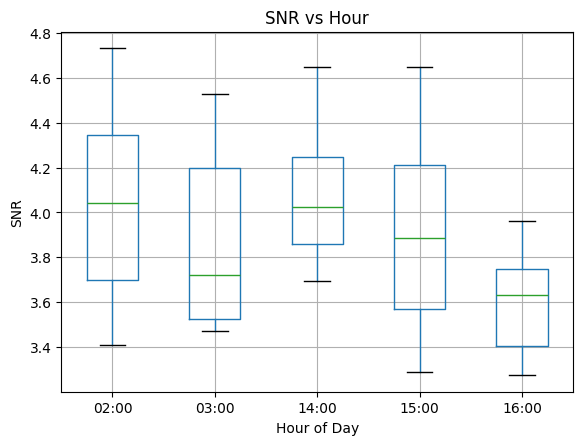

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df.boxplot(column='SNR', by='Hour')
plt.title('SNR vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('SNR')
plt.suptitle('')
plt.show()

<Figure size 1000x600 with 0 Axes>

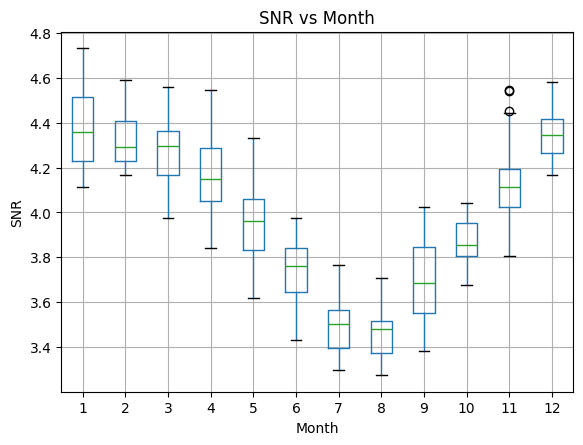

In [24]:
# prompt: snr vs month box plot

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df.boxplot(column='SNR', by='Month')
plt.title('SNR vs Month')
plt.xlabel('Month')
plt.ylabel('SNR')
plt.suptitle('')
plt.show()